# Intro to Open Source Python Geospatial Workshop

This workshop introduces the ecosystem of open source Python tools for working with geospatial data.

* The Python software libraries available for working with vector and raster datasets.
* The basic usage of these libraries to conduct a complete GIS analysis.
* Additional resources for expanding your knowledge of these tools.

## Getting Started

If you want to follow along read-only, visit

> https://github.com/perrygeo/notebooks/

If you want to use a live notebook (allowing you to run this code from a web browser), visit

> https://mybinder.org/v2/gh/perrygeo/notebooks/master

In both cases, the name of the notebook is **Python-Geospatial-Tutorial.ipynb**.


The live notebook is provided for free by a third-party (*mybinder.org*) so there are no guarantees about performance or uptime, caveat emptor.

## Table of Contents

1. Introduction
2. Working with Vector data
3. Working with Raster data
4. Working with Tabular data
5. Analysis
6. Web services

## Introduction

### Audience

This workshop is intended for the beginner-to-intermediate Python programmer familiar with basic concepts from Geographic Information Systems (GIS). 

Before starting, you should be familiar with **Python** concepts such as:

* Writing and running python scripts
* Importing libraries
* Writing functions
* Using the builtin data structures, particularly Python's `list` and `dictionary`
* Looping over lists with `for` and list comprehensions
* Familiarity with `numpy` arrays

An understanding of **GIS concepts** will be helpful, though they will be explained briefly in each section below. This includes:

* The fundamental differences between raster and vector data model
* Analysis techniques for raster and vector data
* Familiarity with spatial referencing systems (projections, datums)
* Basic statsitics

### Format

This workshop uses a [Jupyter Notebook](https://jupyter.org/) to provide an interactive environment for editing both Python code and supporting notes/documentation. 

> The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning, and much more.

Notebooks are an increasingly popular and important part of research and data analysis in both academia and industry. The advantages over traditional Desktop GIS workflows are significant:

* Reproducible
* Documentation and Code live together
* Seamless publishing and collaboration
* Integrated Development Environment (IDE) for analysis

Importantly, we can use the notebook in our web browser - no special tools or installation is required on your machine.

### Case Study


The primary question we will be exploring is:

> How might countries' annual precipiation total be affected by climate change?

We'll use climate model data from [WorldClim](http://www.worldclim.org/version1) to determine the change in precipitation from present day averages to predicted 2070 averages. This data will be aggregated to countries from the [Natural Earth](http://www.naturalearthdata.com/downloads/50m-cultural-vectors/) dataset.

The methods I use here are not valid scientific research, It's simply an exploratory analysis to demonstrate the analysis techniques provided by the software.

### Introducing our Python libraries

Below is a list of the python libraries we'll be using. All of them are open source - freely available and redistributable with no licensing fees. You'll find more information in the respective links below:

* [Rasterio](https://github.com/mapbox/rasterio) - Raster data
* [Fiona](https://github.com/Toblerity/Fiona) - Vector data
* [Shapely](https://github.com/Toblerity/Shapely) - 2D Geometries
* [Numpy](http://www.numpy.org/) - Multidimensional Arrays
* [Pandas](https://pandas.pydata.org/) - Tabular data (i.e. spreadsheets)
* [GeoPandas](http://geopandas.org/) - Pandas extension for vector data analysis
* [Rasterstats](https://github.com/perrygeo/python-rasterstats) - Zonal Statistics
* [MapboxGL](https://github.com/mapbox/mapboxgl-jupyter) - Visualizing vector data in the notebook
* [MapboxSDK](https://github.com/mapbox/mapbox-sdk-py) - Accessing Mapbox web services

These have already been installed on the notebook server; We'll start off by **import**ing them

In [1]:
import rasterio
import shapely
import fiona
import numpy as np
import geopandas
import pandas
import rasterstats
import mapboxgl
import mapbox
import seaborn

import warnings
warnings.simplefilter('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Working with Vector Data

### The vector data model

Vector data represents discrete objects in our world using **geometries** (points, lines, and polygons) referenced to the earth using a coordinate reference system. These discrete geometries are typically paired with **properties** (also called "attributes") which provide extra information about it. Together, the geometry and properties form a **Feature**. For example: a line geometry representing a road plus the road name gives us a vector feature. A dataset containing multiple features is known as a **Feature Collection**.


[GeoJSON](http://geojson.org/) is a specification for encoding vector data for use on the web. It provides a human-readable representation of vector data that illustrates how most Python tools conceptually handle features:

```json
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [-107.3319, 38.2649]
  },
  "properties": {
    "name": "Bridge 400-5"
    "year": 1978
  }
}
```

### Reading vector data files

The most ubiquitous and widely-supported format for distributing and storing spatial data is the [ESRI Shapefile](https://en.wikipedia.org/wiki/Shapefile). We'll start by loading our County polygon features from a shapefile using the **Fiona** library.

In [2]:
fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [3]:
# read one and inspect
with fiona.open('data/countries/ne_50m_admin_0_countries.shp') as features:
    collection = list(features)
    profile = features.profile
    
len(collection)

241

In [4]:
country = collection[106]

country['properties']['NAME']

'Italy'

In [5]:
(country['properties']['GDP_MD_EST'] * 1000000) / country['properties']['POP_EST']

35743.137486581836

### Working with Features

The geometry portion of the Feature is a list of coordinate pairs - an accurate representation but in order perform geometry manipulations, overlays or spatial relationships, we need to use **Shapely**

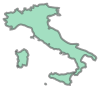

In [6]:
# convert geometry to a shapely shape
shape = shapely.geometry.shape(country['geometry'])
shape

What can we do with these Shapely geometry objects? For single shapes, we have a number of *Unary Predicates* to describe the shape. For example, we could calculate the area (in this case, decimal degrees is not useful but Shapely is agnostic to the projection)

In [7]:
shape.area

33.13435864925385

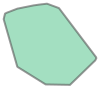

In [8]:
shape.convex_hull

In [9]:
shape.centroid.wkt

'POINT (12.07001254768982 42.79662848728708)'

There are also a number of *Binary Predicates* and *Spatial Analyses* that allow you to explore the spatial relationships between two geometries, perform overlay analysis, etc.

Switzerland


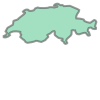

In [10]:
country2 = collection[39]
print(country2['properties']['NAME'])

# geometry -> shapely shape
shape2 = shapely.geometry.shape(country2['geometry'])
shape2

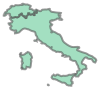

In [11]:
shapely.geometry.collection.GeometryCollection([
    shape, shape2
])

In [12]:
# Do they touch?
shape.touches(shape2)

True

In [13]:
# Do they overlap?
shape.overlaps(shape2)

False

In [14]:
# Distance between centroids (again, in decimal degrees)
shape.centroid.distance(shape2.centroid)

5.560555171092688

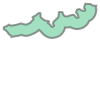

In [15]:
shape.intersection(shape2.buffer(0.5))

Check out the [Shapely user manual](https://toblerity.org/shapely/manual.html) for the full overview.

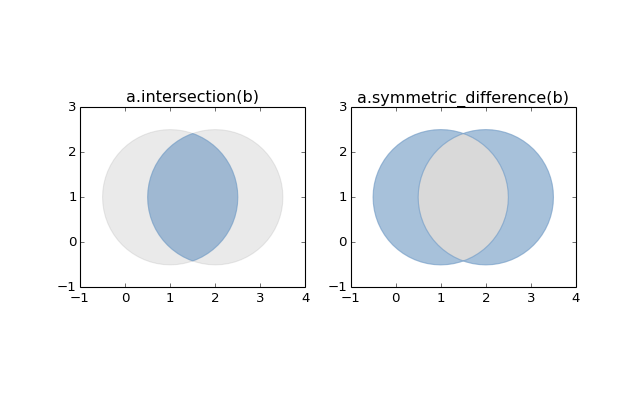

### Writing vector data

Once we've processed (or created from scratch) a Feature collection, we can save it out to a file. Fiona can write to a number of different vector file formats. Let's save our Italy feature to a new feature collection backed by an ESRI Shapefile.

In [16]:
with fiona.open('/tmp/italy.shp', mode='w', **profile) as shp:
    shp.write(country)

### More resources

* https://toblerity.org/shapely/manual.html
* [pyproj](https://jswhit.github.io/pyproj/) for working with projections

## Working with Raster Data

### The raster data model

Raster data represents the world as a continuous surface divided into a regular grid of square pixels. Raster models are useful for data such as e.g. imagery, weather and elevation.

### Reading raster data

**Rasterio** (pronounced "*rast-air-ee-oh*") is our mechanism for accessing Raster data in Python. Under the hood, Rasterio leverages the proven [GDAL](https://gdal.org) library.

> Geographic information systems use GeoTIFF and other formats to organize and store gridded, or raster, datasets. Rasterio reads and writes these formats and provides a Python API based on N-D arrays.


We'll use Rasterio to read the present day annual precipitation data from a GeoTiff file

In [17]:
# Read grid into numpy arrays and store the profile
with rasterio.open('data/precip_current/precip_current.tif') as src:
    current_precip = src.read(1, masked=True)
    profile = src.profile

The `profile` contains the essential metadata for the raster dataset; things like the height, width, cell size and spatial referencing that are necessary to relate the data to the Earth.

In [18]:
profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 8640, 'height': 3600, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.041666668839752674, 0.0, -180.0,
       0.0, -0.041666668839752674, 90.00000782310963), 'blockxsize': 256, 'blockysize': 256, 'compress': 'lzw', 'tiled': True, 'interleave': 'band'}

### Working with Numpy Arrays

The resulting `current_precip` dataset is a **numpy** array, a standard data type that is widely used across the many scientific fields which have adopted Python. Let's take some time to see what we can do with numpy arrays:

In [19]:
# inspect numpy array's shape
current_precip.shape

(3600, 8640)

In [20]:
# Clip out a subset of the data
current_precip[400:403, 6820:6823]

masked_array(
  data=[[262, 262, 261],
        [263, 263, 263],
        [263, 264, 263]],
  mask=[[False, False, False],
        [False, False, False],
        [False, False, False]],
  fill_value=-32768,
  dtype=int16)

In [21]:
# Basic Maths
current_precip_inches = current_precip / 25.4
current_precip_inches[400:403, 6820:6823]

masked_array(
  data=[[10.314960629921261, 10.314960629921261, 10.275590551181104],
        [10.354330708661418, 10.354330708661418, 10.354330708661418],
        [10.354330708661418, 10.393700787401576, 10.354330708661418]],
  mask=[[False, False, False],
        [False, False, False],
        [False, False, False]],
  fill_value=-32768)

In [22]:
current_precip_inches.min(), current_precip_inches.max()

(0.0, 416.4173228346457)

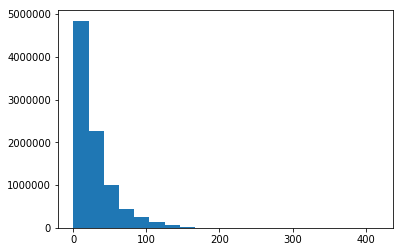

In [23]:
plt.hist(current_precip_inches.flatten(), bins=20);

We can plot the raster in the notebook using imshow

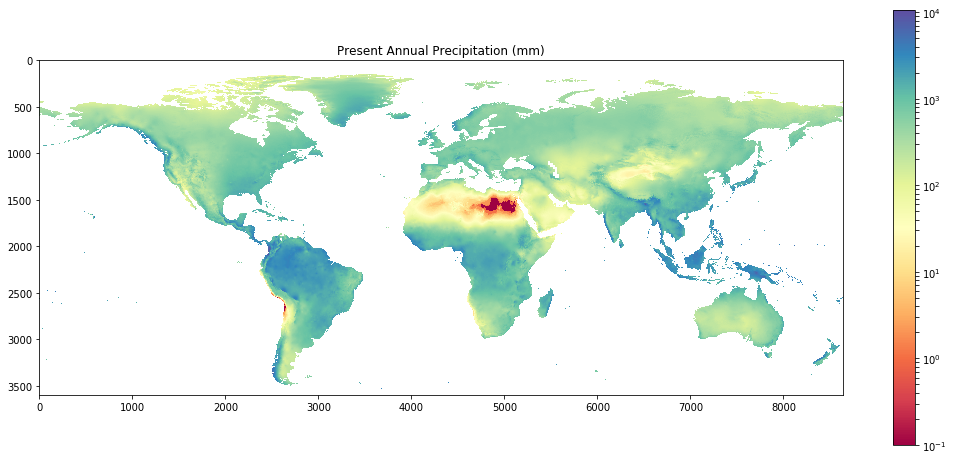

In [24]:
figure(figsize = (18,8))
from matplotlib.colors import LogNorm, SymLogNorm

imshow(current_precip + 0.1, cmap='Spectral', norm=LogNorm())
title('Present Annual Precipitation (mm)')
colorbar()

### Calculating precipitation change

We can load data from a climate model and compare it to present day precipitation to calculate the predicted change in precipitation.

The data come from the [CCSM4](http://www.cesm.ucar.edu/models/ccsm4.0/) climate model for the year 2070 under the RCP 6.0 scenario. A rigourous study of climate change would consider these details in far more depth; for the purposes of this workshop, we'll just call it "Future precipitation" and make the assumption that this is reasonable model.

The data comes in GeoTiff format. Let's load it up with Rasterio.

In [25]:
with rasterio.open('data/precip_2070/precip_cc_2070_rcp60.tif') as src:
    future_profile = src.profile
    future_precip = src.read(1, masked=True)

In [26]:
# gut check to ensure the raster grids are aligned
future_precip.shape == current_precip.shape

True

We can calculate the raw difference between the grids as a measure of precipation change

In [27]:
change_precip = future_precip - current_precip

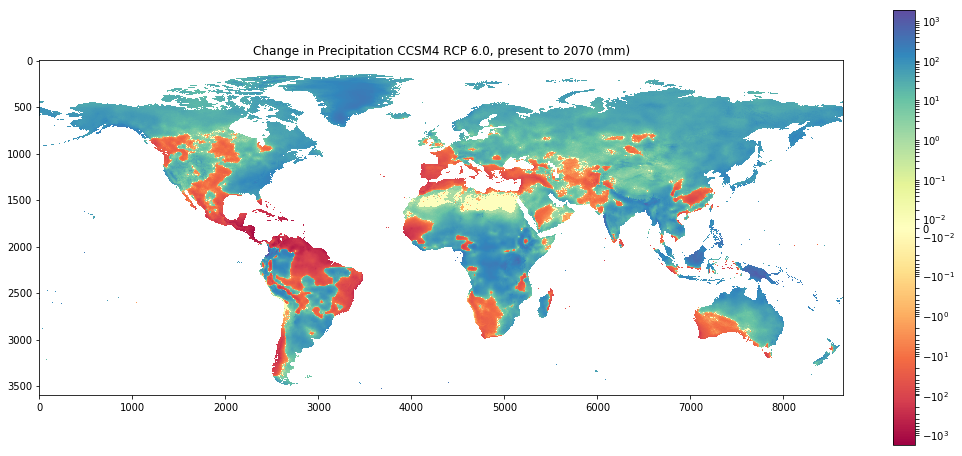

In [28]:
# plot
figure(figsize = (18,8))
imshow(change_precip, cmap='Spectral', norm=SymLogNorm(linthresh=0.03))
title('Change in Precipitation CCSM4 RCP 6.0, present to 2070 (mm)')
colorbar()

### Writing raster data

Once we have created an array containing our new/derived data, we can save it out to a Raster data format.

Since we haven't changed the size, shape or spatial referencing of the array, we can reference the original `profile` metadata when creating a new file. But instead of saving to an ESRI Grid, we can output a GeoTiff which has wider support across many software implementations.

In [29]:
with rasterio.open('/tmp/precip_change.tif', mode='w', **profile) as dst:
    dst.write(change_precip, 1)

### More resources

* **Rasterio** provides interesting spatial functionality that is outside the scope of this workshop but may be required for other analyses. Check out the [Rasterio Manual](https://mapbox.github.io/rasterio/) for more.
* **Numpy** [tutorial](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)
* **SciPy** - scientific python library for more advanced array/matrix processing (https://www.scipy.org/)

## Working with Tabular Data

Spreadsheets and other forms of non-spatial data play a significant role in many GIS projects. Commonly, we'll
need to aggregate and filter data, create summary statistics and join the results with other datasets. This is where the GIS world overlaps significantly with the emerging field of "Data Science".

**Pandas** is the tool of choice for Python data scientists. Pandas can load spreadsheets, csvs and other structured datasets into an abstraction called the **Data Frame** which provides high-level methods for many common data analyses.

### Reading tabular data

Pandas can load standard table formats like Excel and CSV.

The **GeoPandas** extension lets you use GIS formats as well, effectively treating your vector features as rows in a spreadsheet, with `geometry` being a special column for the spatial data.

Let's load this directly into a pandas geodata frame. Note: there are similar methods for reading Excel files, SQL databases, etc.

In [30]:
gdf = geopandas.read_file("data/countries/ne_50m_admin_0_countries.shp")
gdf.columns

Index(['scalerank', 'featurecla', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'geometry'],
      dtype='object')

Calculate a new column

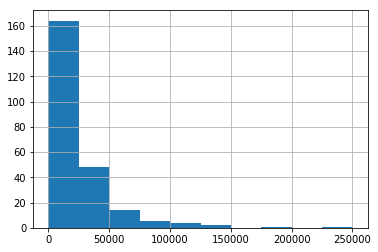

In [31]:
gdf['GDP_PER_CAPITA'] = gdf.GDP_MD_EST * 1000000 / gdf.POP_EST
gdf['GDP_PER_CAPITA'].hist()

Calculate new columns using shapely operations on the geometry

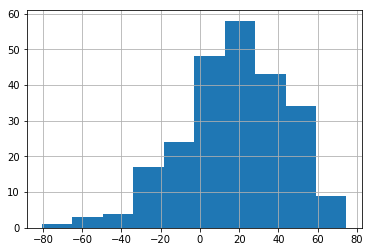

In [32]:
gdf['CENTER_LAT'] = gdf.geometry.centroid.y
gdf['CENTER_LAT'].hist()

We can use a plotting library like [Seaborn](https://seaborn.pydata.org/) to do some exploratory visualization of the non-spatial relationships within the data.

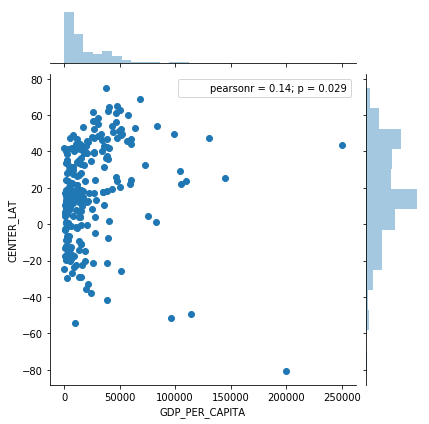

In [33]:
seaborn.jointplot("GDP_PER_CAPITA", "CENTER_LAT", data=gdf)

### More resources

* Pandas: https://pandas.pydata.org/index.html
* GeoPandas: http://geopandas.org/
* Statistical models: https://www.statsmodels.org/stable/index.html
* Plotting: the python visualization landscape: https://www.youtube.com/watch?v=FytuB8nFHPQ

## Geospatial Analysis

Now that we've seen how to handle vector, raster and tabular data in Python, we can move into Analysis. IN this example we'll use our country dataset as spatial units to aggregate the precipitation change data. We can do this using a technique called **zonal statistics** to bridge the gap between the raster and vector data models.


In [34]:
?rasterstats.gen_zonal_stats

In [35]:
precip_delta = rasterstats.zonal_stats(gdf, '/tmp/precip_change.tif', prefix='pr_delta_', all_touched=True)

In [36]:
precip_delta[106]

{'pr_delta_count': 19810,
 'pr_delta_max': 63.0,
 'pr_delta_mean': -13.378546188793539,
 'pr_delta_min': -91.0}

Join the precipitation data back to the original GeoDataFrame, creating a new version

In [37]:
calc_gdf = gdf.join(pandas.DataFrame(precip_delta))

The zonal statistics are available as properties on the Features. For instance, the mean annual precipitation change for Italy is projected to be...

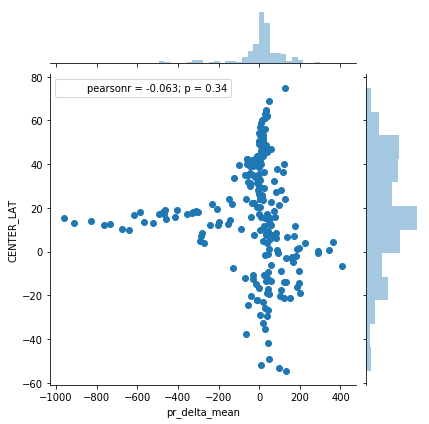

In [38]:
# Compare precipitation change to latitude
seaborn.jointplot("pr_delta_mean", "CENTER_LAT", data=calc_gdf)

GeoPandas has some built in plotting features for doing choropleth maps.

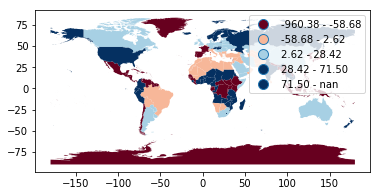

In [39]:
calc_gdf.plot(column='pr_delta_mean', cmap='RdBu', scheme='quantiles', legend=True)

Now let's plot the features in an interactive map. Because we're trying to show the average magnitude of change within a spatial unit, using a graduated circle symbol might be a more effective visualization than a choropleth map

First we can calculate a new `centroid` geometry column

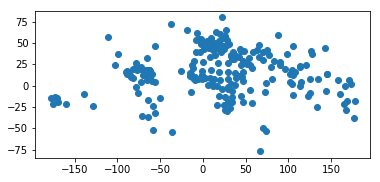

In [40]:
calc_gdf['centroid'] = calc_gdf.geometry.representative_point()
centroid_gdf = calc_gdf.set_geometry('centroid')
centroid_gdf.plot()

Do a little work to remove the old geometry column and extraneous columns


In [41]:
keep = ['pr_delta_mean', 'CENTER_LAT', 'GDP_PER_CAPITA', 'NAME']

collection = {
    'type': 'FeatureCollection',
    'features': []
}

for f in centroid_gdf.__geo_interface__['features']:
    new_properties = {}
    for k, v in f['properties'].items():      
        if k in keep:
            new_properties[k] = v
    f['properties'] = new_properties
    collection['features'].append(f)

Then set up the classification (quantiles) and plot it

In [42]:
from mapboxgl.utils import create_radius_stops, create_color_stops
from mapboxgl.viz import GraduatedCircleViz

token = 'pk.eyJ1IjoicGVycnlnZW8iLCJhIjoiY2o2MTFlYjFsMHIzbjJxbW93M2YzY2VqdiJ9.BczmcdVkwAXfjmp-yr91kA'
measure = 'pr_delta_mean'

# Generate radius breaks from data domain and circle-radius range
radius_breaks = [round(centroid_gdf['GDP_PER_CAPITA'].quantile(q=x*0.1), 2) for x in range(1,9)]
radius_stops = create_radius_stops(radius_breaks, 5, 10)

# Generate data breaks using numpy quantiles and color stops from colorBrewer
color_breaks = [round(centroid_gdf[measure].quantile(q=x*0.1), 2) for x in range(1,9)]
color_stops = create_color_stops(color_breaks, colors='RdYlBu')

# Create the viz
viz = GraduatedCircleViz(
    collection, 
    height='400px',
    access_token=token,
    radius_property='GDP_PER_CAPITA',
    radius_stops=radius_stops,
    color_property=measure,
    color_stops=color_stops,
    center=(0, 0),
    zoom=0,
    opacity=0.75)

with open('_viz.html', 'w') as fh:
    fh.write(viz.create_html())

width = '900px'
height = '500px'
from IPython.core.display import HTML, display
display(HTML(f'<iframe id="plot" src="_viz.html" style="width: {width}; height: {height};"></iframe>'))

### More resources

* GeoPandas docs have some good examples of overlay analysis: https://geopandas.readthedocs.io/en/latest/set_operations.html
* See the GeoPandas example notebooks: https://github.com/geopandas/geopandas/wiki/Notebooks
* MapboxGL Jupyter examples: https://nbviewer.jupyter.org/github/mapbox/mapboxgl-jupyter/blob/master/examples/point-viz-types-example.ipynb

## Web services

Until this point in the workshop, we've been dealing with data and analyses directly in our notebook. For many types of questions, the volume of data and the processing required to handle it are too expensive to undertake as a one-off analyis. Consider tasks such as **geocoding** or **driving directions** - these require carefully curated points of interest and road network datasets respectively, plus the infrastructure to handle the analysis.

Mapbox provides access to such data and infrastructure using **web services**, allowing us to make HTTP requests which handle the details and return results quickly. To access them via Python, we can use the Mapbox Python SDK.

Note: This requires a Mapbox account token. See https://www.mapbox.com/account/

For example, we could geocode a list of addresses and collect the results as vector Features.

In [43]:
address = '510 S College Ave, Fort Collins, CO 80524, USA'   # Big City Burrito

geocoder = mapbox.Geocoder(access_token=token)
geocoder.forward(address).geojson()['features'][0]

{'address': '510',
 'center': [-105.07656, 40.581013],
 'context': [{'id': 'neighborhood.283365', 'text': 'Old Town West'},
  {'id': 'postcode.9983073121077410', 'text': '80524'},
  {'id': 'place.8482904060013100',
   'text': 'Fort Collins',
   'wikidata': 'Q490732'},
  {'id': 'region.28679',
   'short_code': 'US-CO',
   'text': 'Colorado',
   'wikidata': 'Q1261'},
  {'id': 'country.3145',
   'short_code': 'us',
   'text': 'United States',
   'wikidata': 'Q30'}],
 'geometry': {'coordinates': [-105.07656, 40.581013], 'type': 'Point'},
 'id': 'address.5903202333550538',
 'matching_place_name': '510 South College Avenue, Fort Collins, Colorado 80524, USA',
 'place_name': '510 South College Avenue, Fort Collins, Colorado 80524, United States',
 'place_type': ['address'],
 'properties': {},
 'relevance': 0.8999999999999999,
 'text': 'South College Avenue',
 'type': 'Feature'}

Another use case for web services is publishing. For example, Mapbox provides an **Uploads** web service to publish vector and raster datasets as Mapbox Vector Tiles (MVT) for use in web mapping applications.